# IS-4100 Lab Assignment: Exploring Poisson Regression with NFL Data

**Objective**

Use NFL play-by-play data to explore and apply Poisson regression for modeling count data. A great use case could be the number of touchdowns scored by teams during games.

**Assignment Overview**

You will work through the following key steps:

**Setup and Data Acquisition**
- Install necessary packages (e.g., `nfl_data_py` or `nflfastR`).
- Import essential libraries for data manipulation and visualization.
- Load NFL play-by-play data.


**Data Preparation and Feature Engineering**
- Compute predictor variables that may influence dependent variable.
- Create a final dataset for modeling, ensuring proper handling of missing values.

**Exploratory Data Analysis (EDA)**
- Visualize the distribution of your response variable.
- Analyze the distribution to assess suitability for Poisson regression.
- Explore relationships between predictors and the target variable.


**Modeling**
- Fit a Poisson Regression Model
- Interpret the Model
- Analyze model coefficients and their statistical significance.
- Explain the effect of each predictor on the expected number of touchdowns.

**Assess Model Fit**
- Evaluate the goodness-of-fit using appropriate metrics.
- Check for overdispersion (variance greater than the mean).


**Model Diagnostics and Refinement**
- If overdispersion is detected:
  - Fit a Negative Binomial regression model as an alternative.
  - Compare the Poisson and Negative Binomial models.
  - Determine which model better fits the data and justify your choice.

**Reporting and Conclusions**
- Summarize your findings in a clear and concise manner.
- Discuss any insights gained from the analysis.
- Reflect on the modeling process, including any challenges or limitations.
- Document your work thoroughly within the notebook, using markdown cells to explain each step.

##**Setup and Data Acquisition**

In [ ]:
# load in packages
!pip install nfl_data_py
import pandas as pd
import nfl_data_py as nfl
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 21.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
mizani 0.11.4 requires pandas>=2.1.0, but you have pandas 1.5.3 which is incompatible.
plotnine 0.13.6 requires pandas<3.0.0,>=2.1.0, but you have pandas 1.5.3 which is incompatible.
xarray 2024.9.0 requires pandas>=2.1, but you have pandas 1.5.3 w

In [ ]:
seasons = range(2017, 2024)
pbp = nfl.import_pbp_data(seasons)

2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [ ]:
# Grabbing the columns I want to look at/use for EDA and Modeling
cols = ['game_id', 'posteam', 'defteam', 'passing_yards', 'rushing_yards', 'play_type',
           'third_down_converted', 'third_down_failed', 'penalty_yards',
           'interception', 'fumble_lost', 'touchdown', 'posteam_score', 'defteam_score',
           'total_home_score', 'total_away_score', 'total_line', 'season', 'week']

pbp = pbp[cols]

# Add turnovers field
pbp['turnovers'] = pbp['interception'] + pbp['fumble_lost']

# Group by and aggregate for game by game dataframe
gbg = pbp.groupby(['game_id', 'posteam', 'season', 'week']).agg(
    passing_yards=('passing_yards', 'sum'),
    rushing_yards=('rushing_yards', 'sum'),
    turnovers=('turnovers', 'sum'),
    penalties=('penalty_yards', 'sum'),
    third_down_converted=('third_down_converted', 'sum'),
    third_down_failed=('third_down_failed', 'sum'),
    touchdowns=('touchdown', 'sum'),
    points_scored=('posteam_score', 'max'),
    total_line=('total_line', 'mean'),

).reset_index()

# Calculate third down conversion rate
gbg['third_down_conversion_rate'] = gbg['third_down_converted'] / (gbg['third_down_converted'] + gbg['third_down_failed'])

gbg.head()

<ipython-input-3-272342d3a8eb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp['turnovers'] = pbp['interception'] + pbp['fumble_lost']


,game_id,posteam,season,week,passing_yards,rushing_yards,turnovers,penalties,third_down_converted,third_down_failed,touchdowns,points_scored,total_line,third_down_conversion_rate
0,2017_01_ARI_DET,ARI,2017,1,268.0,45.0,4.0,116.0,6.0,9.0,3.0,23.0,48.5,0.400000
1,2017_01_ARI_DET,DET,2017,1,292.0,82.0,1.0,39.0,8.0,8.0,5.0,35.0,48.5,0.500000
2,2017_01_ATL_CHI,ATL,2017,1,321.0,64.0,0.0,63.0,5.0,6.0,2.0,23.0,48.0,0.454545
3,2017_01_ATL_CHI,CHI,2017,1,213.0,125.0,0.0,50.0,5.0,8.0,2.0,17.0,48.0,0.384615
4,2017_01_BAL_CIN,BAL,2017,1,121.0,157.0,1.0,87.0,6.0,8.0,2.0,20.0,41.5,0.428571


In [ ]:
gbg.describe()

,season,week,passing_yards,rushing_yards,turnovers,penalties,third_down_converted,third_down_failed,touchdowns,points_scored,total_line,third_down_conversion_rate
count,3848.000000,3848.00000,3848.000000,3848.000000,3848.000000,3848.000000,3848.000000,3848.000000,3848.000000,3848.000000,3848.000000,3848.000000
mean,2020.055094,9.68763,245.593811,114.910339,1.325884,51.482849,5.116684,7.791840,2.576144,22.471153,45.417099,0.391566
std,2.003138,5.44468,75.793159,51.305523,1.186668,27.487446,2.190951,2.133455,1.437712,10.048537,4.577866,0.141073
min,2017.000000,1.00000,7.000000,-1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,28.500000,0.000000
25%,2018.000000,5.00000,193.000000,78.000000,0.000000,30.000000,4.000000,6.000000,2.000000,16.000000,42.000000,0.300000
50%,2020.000000,10.00000,241.000000,108.000000,1.000000,48.000000,5.000000,8.000000,2.000000,22.000000,45.000000,0.384615
75%,2022.000000,14.00000,296.000000,145.000000,2.000000,68.000000,6.000000,9.000000,4.000000,29.000000,48.500000,0.500000
max,2023.000000,22.00000,525.000000,404.000000,7.000000,195.000000,14.000000,19.000000,10.000000,70.000000,63.500000,0.900000


##**EDA**

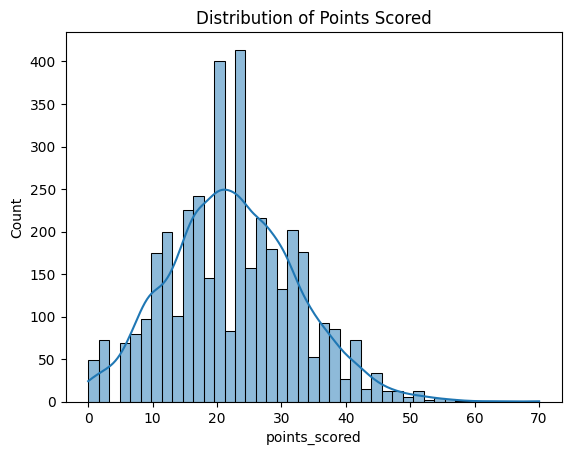

In [ ]:
sns.histplot(gbg['points_scored'], kde=True)
plt.title('Distribution of Points Scored')
plt.show()

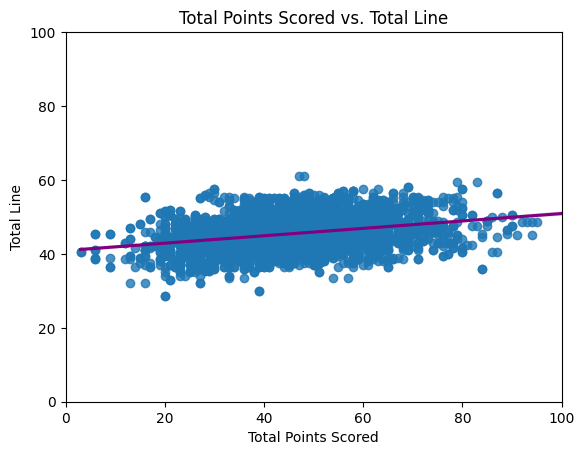

In [ ]:
# Want to compare the Total Line vs. The Total Result
# Aggregate to get the final scores for both teams in each game
scores = pbp.groupby(['game_id', 'posteam']).agg(
    posteam_score=('posteam_score', 'max'),
    defteam_score=('defteam_score', 'max'),
    total_line=('total_line', 'mean')
).reset_index()

# Add total points scored column
scores['total_points_scored'] = scores['posteam_score'] + scores['defteam_score']

# Create Reg plot
sns.regplot(
    data=scores,
    x='total_points_scored',
    y='total_line',
    line_kws={'color': 'purple'}
)

# Ensures both axis' match
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xticks(range(0, 101, 20))
plt.yticks(range(0, 101, 20))

plt.title('Total Points Scored vs. Total Line')
plt.xlabel('Total Points Scored')
plt.ylabel('Total Line')

plt.show()

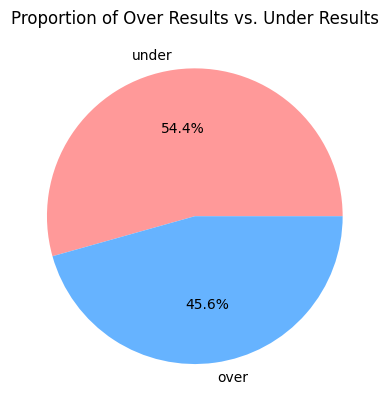

In [ ]:
# Compare the proportion of "over's" vs. "under's"
scores['over_under'] = scores.apply(lambda row: 'over' if row['total_points_scored'] > row['total_line'] else 'under', axis=1)

agg_scores = scores[['game_id', 'posteam', 'total_line', 'posteam_score', 'defteam_score', 'total_points_scored', 'over_under']]

over_under_count = scores['over_under'].value_counts()

plt.pie(over_under_count, labels=over_under_count.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
plt.title('Proportion of Over Results vs. Under Results')

plt.show()

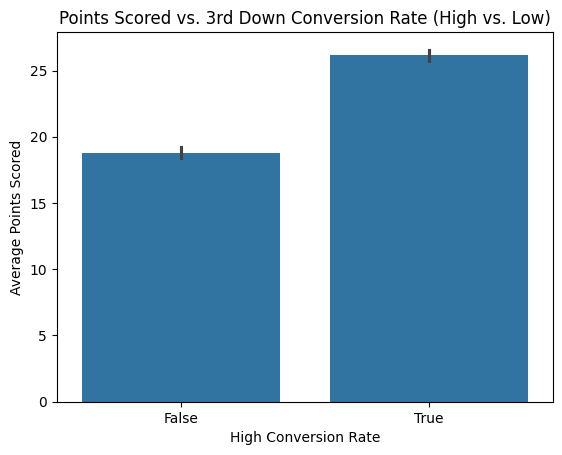

In [ ]:
# Looking at the effect of better 3rd down conversion rate and points scored
gbg['conversion_rate_high_low'] = gbg['third_down_conversion_rate'] > gbg['third_down_conversion_rate'].median()

sns.barplot(x='conversion_rate_high_low', y='points_scored', data=gbg)
plt.title('Points Scored vs. 3rd Down Conversion Rate (High vs. Low)')
plt.xlabel('High Conversion Rate')
plt.ylabel('Average Points Scored')
plt.show()

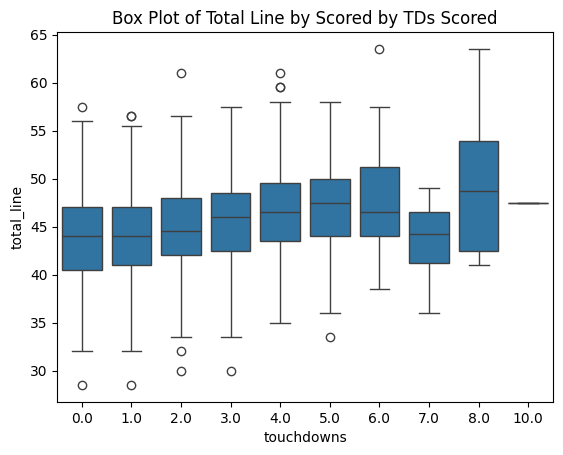

In [ ]:
# box plotting the pregame total line's with the number of TD's scored by individual team's
sns.boxplot(x='touchdowns', y='total_line', data=gbg)
plt.title('Box Plot of Total Line by Scored by TDs Scored')
plt.show()

In [ ]:
# calculate mean for Poisson
touchdowns_mean = gbg.touchdowns.mean()

touchdowns_mean

2.5761435

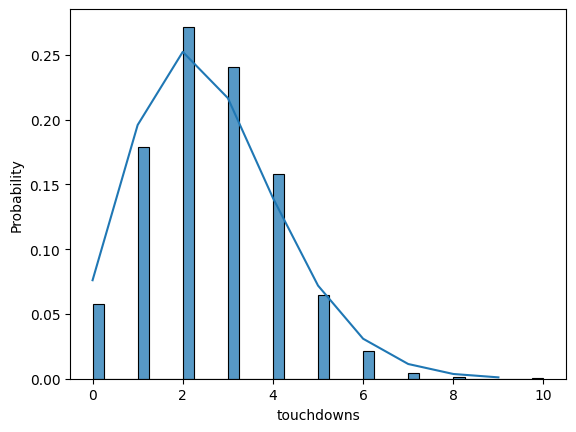

In [ ]:
# list comprehension
# PMF for Poisson
plot_pos_py = pd.DataFrame(
    {
        'x': range(0,10),
        'expected': [poisson.pmf(x, touchdowns_mean) for x in range(0,10)]
    }
)

# hist plot - seaborn
sns.histplot(
    gbg['touchdowns'],
    stat = 'probability'
)

plt.plot(plot_pos_py.x, plot_pos_py.expected)
plt.show()

##**Poisson Modeling**

In [ ]:
# Initialize an empty DataFrame to store results
x_td = pd.DataFrame()

# Loop over seasons and weeks (2017-2023)
for season_idx in range(2017, 2023 + 1):
    for week_idx in range(1, 22 + 1):  # 22 is the maximum possible number of weeks in a season including playoffs
        # Filter data to get current and past season data up to the current week
        week_calc_td = (
            pbp.query(
                '(season == ' + str(season_idx - 1) + ') | ' +
                '(season == ' + str(season_idx) + ' & week <= ' + str(week_idx) + ')'
            )
            .groupby(['posteam'])  # Group by team (posteam)
            .agg(
                touchdowns=('touchdown', 'sum'),  # Sum total touchdowns
                n_games=('game_id', 'nunique')  # Count unique game IDs for total games played
            )
        )

        # Calculate td_rate: total touchdowns divided by the number of games
        week_calc_td['td_rate'] = week_calc_td['touchdowns'] / week_calc_td['n_games']

        # Reset index to prepare the DataFrame
        week_calc_td.reset_index(inplace=True)

        # Add season and week columns to the DataFrame
        week_calc_td['season'] = season_idx
        week_calc_td['week'] = week_idx

        # Concatenate with the main DataFrame
        x_td = pd.concat([x_td, week_calc_td])

# Display the result
x_td.tail(15)

,posteam,touchdowns,n_games,td_rate,season,week
17,LAC,83.0,35,2.371429,2023,22
18,LV,75.0,34,2.205882,2023,22
19,MIA,110.0,36,3.055556,2023,22
20,MIN,93.0,35,2.657143,2023,22
21,NE,64.0,34,1.882353,2023,22
22,NO,83.0,34,2.441176,2023,22
23,NYG,71.0,36,1.972222,2023,22
24,NYJ,51.0,34,1.500000,2023,22
25,PHI,123.0,38,3.236842,2023,22
26,PIT,60.0,35,1.714286,2023,22


In [ ]:
# Rename columns in x_td to avoid duplicates
x_td.rename(columns={
    'touchdowns': 'tds',
    'n_games': 'total_games',
    'td_rate': 'td_rate'
}, inplace=True)

# Merge with gbg
model_df = pd.merge(gbg, x_td, on=['season', 'week', 'posteam'], how='left')

model_df.tail(5)

,game_id,posteam,season,week,passing_yards,rushing_yards,turnovers,penalties,third_down_converted,third_down_failed,touchdowns,points_scored,total_line,third_down_conversion_rate,conversion_rate_high_low,tds,total_games,td_rate
3843,2023_21_DET_SF,SF,2023,21,267.0,155.0,1.0,30.0,6.0,6.0,4.0,34.0,52.5,0.500000,True,126.0,39,3.230769
3844,2023_21_KC_BAL,BAL,2023,21,272.0,81.0,3.0,25.0,3.0,8.0,1.0,7.0,44.0,0.272727,False,99.0,37,2.675676
3845,2023_21_KC_BAL,KC,2023,21,241.0,89.0,0.0,100.0,8.0,10.0,2.0,17.0,44.0,0.444444,True,115.0,40,2.875000
3846,2023_22_SF_KC,KC,2023,22,333.0,130.0,3.0,15.0,9.0,10.0,2.0,25.0,47.0,0.473684,True,117.0,41,2.853659
3847,2023_22_SF_KC,SF,2023,22,276.0,110.0,1.0,80.0,3.0,9.0,2.0,19.0,47.0,0.250000,False,128.0,40,3.200000


In [ ]:
# fit td_model poisson
td_model = smf.glm(
    formula='touchdowns ~ passing_yards + rushing_yards + turnovers + penalties + third_down_conversion_rate + total_line + td_rate',
    data=model_df,
    family=sm.families.Poisson()
).fit()

# predict with model - expected Team TD's
model_df['exp_tds'] = td_model.predict()

print(td_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             touchdowns   No. Observations:                 3848
Model:                            GLM   Df Residuals:                     3840
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6146.4
Date:                Thu, 24 Oct 2024   Deviance:                       2161.7
Time:                        17:48:21   Pearson chi2:                 1.88e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2933
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [ ]:
# Convert log scale coefficients back to original scale
np.exp(td_model.params)

,0
Intercept,0.369342
passing_yards,1.002967
rushing_yards,1.003569
turnovers,0.965513
penalties,1.000908
third_down_conversion_rate,2.155756
total_line,0.998903
td_rate,1.207604


In [ ]:
## PMF & CDF

model_df['p_0_td'] = poisson.pmf(
    k = 0, mu = model_df['exp_tds']
)

model_df['p_1_td'] = poisson.pmf(
    k = 1, mu = model_df['exp_tds']
)

model_df['p_2_td'] = poisson.pmf(
    k = 2, mu = model_df['exp_tds']
)

model_df['p_3_td'] = poisson.pmf(
    k = 3, mu = model_df['exp_tds']
)

model_df['p_4_td'] = poisson.pmf(
    k = 4, mu = model_df['exp_tds']
)

model_df['p_5_td'] = poisson.pmf(
    k = 5, mu = model_df['exp_tds']
)

model_df['p_g5_td'] = 1 - poisson.cdf(
    k = 5, mu = model_df['exp_tds']
)

model_df.tail(15)

,game_id,posteam,season,week,passing_yards,rushing_yards,turnovers,penalties,third_down_converted,third_down_failed,...,total_games,td_rate,exp_tds,p_0_td,p_1_td,p_2_td,p_3_td,p_4_td,p_5_td,p_g5_td
3833,2023_19_PIT_BUF,PIT,2023,19,229.0,106.0,2.0,54.0,5.0,6.0,...,35,1.714286,1.950488,0.142205,0.277368,0.270502,0.175870,0.085758,0.033454,0.014842
3834,2023_20_GB_SF,GB,2023,20,194.0,136.0,2.0,71.0,7.0,6.0,...,36,2.583333,2.466990,0.084840,0.209299,0.258169,0.212300,0.130936,0.064603,0.039852
3835,2023_20_GB_SF,SF,2023,20,252.0,111.0,0.0,17.0,10.0,6.0,...,38,3.210526,3.292873,0.037147,0.122320,0.201393,0.221053,0.181975,0.119844,0.116267
3836,2023_20_HOU_BAL,BAL,2023,20,152.0,229.0,0.0,30.0,4.0,8.0,...,36,2.722222,2.769333,0.062704,0.173648,0.240444,0.221957,0.153668,0.085112,0.062468
3837,2023_20_HOU_BAL,HOU,2023,20,175.0,38.0,0.0,55.0,4.0,8.0,...,36,2.222222,1.397535,0.247206,0.345478,0.241409,0.112459,0.039291,0.010982,0.003174
3838,2023_20_KC_BUF,BUF,2023,20,186.0,170.0,0.0,20.0,7.0,7.0,...,37,3.189189,3.048214,0.047444,0.144618,0.220414,0.223956,0.170666,0.104046,0.088857
3839,2023_20_KC_BUF,KC,2023,20,215.0,146.0,1.0,23.0,1.0,4.0,...,39,2.897436,2.219167,0.108700,0.241223,0.267657,0.197992,0.109844,0.048752,0.025833
3840,2023_20_TB_DET,DET,2023,20,287.0,114.0,0.0,25.0,6.0,8.0,...,36,3.388889,3.311058,0.036478,0.120779,0.199954,0.220686,0.182676,0.120970,0.118457
3841,2023_20_TB_DET,TB,2023,20,349.0,89.0,2.0,25.0,4.0,8.0,...,37,2.027027,2.439180,0.087232,0.212775,0.259499,0.210988,0.128659,0.062765,0.038081
3842,2023_21_DET_SF,DET,2023,21,273.0,182.0,1.0,5.0,6.0,6.0,...,37,3.405405,4.053062,0.017369,0.070398,0.142664,0.192742,0.195299,0.158312,0.223217


In [ ]:
# Check Dispersion
# Calculate residuals
resid = (model_df['touchdowns'] - model_df['exp_tds']) / np.sqrt(model_df['exp_tds'])

# Calculate Chi Squared
chi_sq = np.sum(resid**2)

# Calculate degrees of freedom
model_residuals = model_df.shape[0] - len(td_model.params)

dispersion = chi_sq / model_residuals
dispersion

0.49023587542839203

- Not overdistributed, no negative binomial model needed

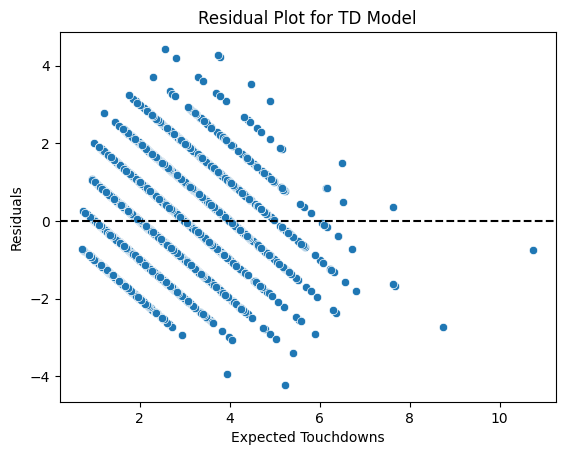

In [ ]:
# Calculate residuals (actual touchdowns - expected touchdowns)
model_df['residuals'] = model_df['touchdowns'] - model_df['exp_tds']

# Residual plot
sns.scatterplot(x=model_df['exp_tds'], y=model_df['residuals'])
plt.axhline(0, linestyle='--', color='black')
plt.xlabel('Expected Touchdowns')
plt.ylabel('Residuals')
plt.title('Residual Plot for TD Model')
plt.show()

- No Funnel or curve shape

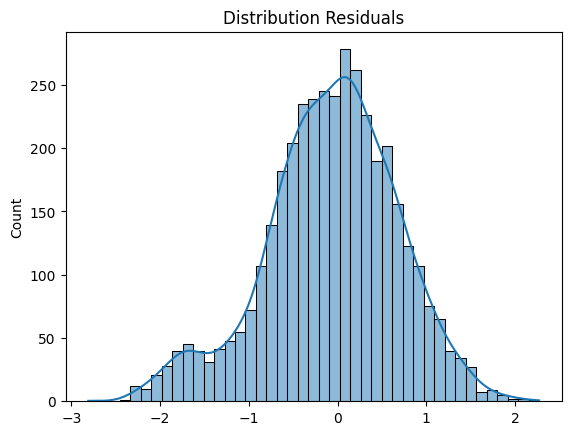

In [ ]:
deviance_residuals = td_model.resid_deviance
sns.histplot(deviance_residuals, kde=True)
plt.title('Distribution Residuals')
plt.show()

- Fairly balanced residuals, slightly leaning negative towards overestimation of TD's

##**Reporting**

- Third Down Conversion % is the strongest factor I evaluated in estimating the number of TD's a team will score in a game
- Previous TD Rate is also strong
- The game's pre-game Total Line is not as strong of a factor as I would have thought
  - A team's Total Line is surely a better indicator